Автор: Мулашкина Татьяна <br>
Дата: 06.06.2025

# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [3]:
#sessions_history = pd.read_csv('sessions_project_history.csv')
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [4]:
#рассчитаем колчичество пропусков в столбцах user_id и session_id
empty_values = sessions_history[['user_id','session_id']].isna().sum()

print('Количество пропущенных значений в столбцах user_id и session_id датафрейма sessions_history:')
empty_values


Количество пропущенных значений в столбцах user_id и session_id датафрейма sessions_history:


user_id       0
session_id    0
dtype: int64

In [5]:
#рассчитаем количество полных дубликатов
full_diplicates = sessions_history.duplicated().sum()

print(f'Количество полных дубликатов в датафрейме sessions_history: {full_diplicates}')

Количество полных дубликатов в датафрейме sessions_history: 0


In [6]:
#рассчитаем количество дубликатов в столбце session_id
session_id_duplicates = sessions_history.duplicated(subset = 'session_id').sum()

print(f'Количество дубликатов в столбце user_id датафрейма sessions_history: {session_id_duplicates}')

Количество дубликатов в столбце user_id датафрейма sessions_history: 0


In [7]:
sessions_history.groupby('user_id')['session_id'].nunique().reset_index().sort_values(by = 'session_id', ascending
 = False)

,user_id,session_id
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10
72346,8A60431A825D035B,9
109383,D11541BAC141FB94,9
47956,5BCFE7C4DCC148E9,9
...,...,...
15859,1DF13BB1953B3497,1
51449,628502A3CE7E0A3C,1
15853,1DEEF40DEFBD0C65,1
89905,AC08479B7472C628,1


In [8]:
df = sessions_history.groupby('user_id')['session_id'].nunique().reset_index().sort_values(by = 'session_id', ascending
 = False)
max_session_user_id = df.iloc[0]['user_id']

sessions_history[sessions_history['user_id'] == max_session_user_id]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

/tmp/ipykernel_34/671106974.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_34/671106974.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


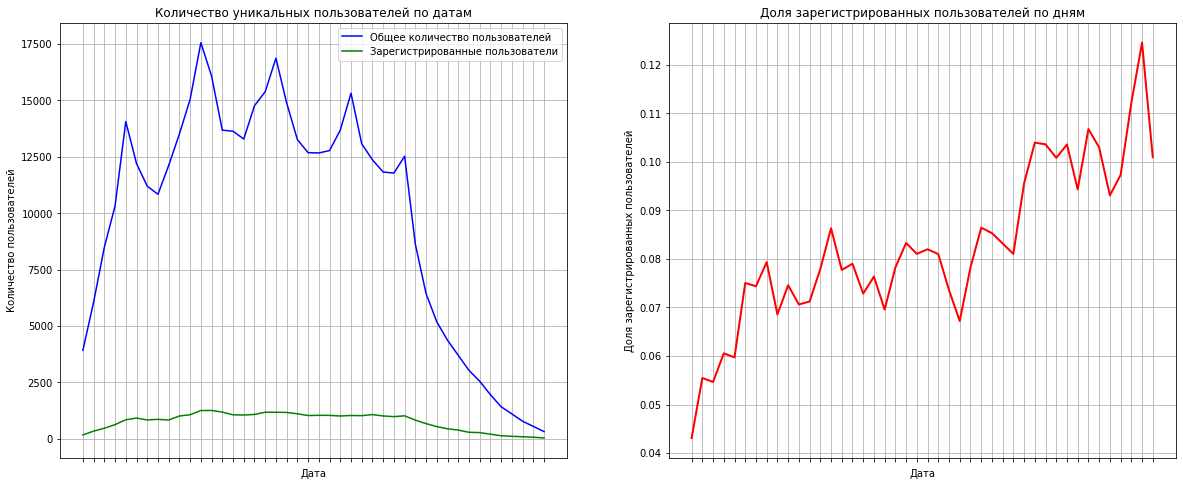

In [9]:
all_users = sessions_history.groupby('session_date')['user_id'].nunique()
registered_users = sessions_history[sessions_history['registration_flag'] == 1].groupby('session_date')['user_id'].nunique()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(all_users, color='blue', label='Общее количество пользователей')
axs[0].plot(registered_users, color='green', label='Зарегистрированные пользователи')
axs[0].set_title('Количество уникальных пользователей по датам')
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Количество пользователей')
axs[0].legend()
axs[0].grid()
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)


users_flag = sessions_history.groupby('session_date').agg({'user_id': 'nunique', 'registration_flag': 'sum'})
users_rat = users_flag['registration_flag'] / users_flag['user_id']

axs[1].plot(users_rat, color='red', linewidth=2)
axs[1].set_title('Доля зарегистрированных пользователей по дням')
axs[1].set_xlabel('Дата')
axs[1].set_ylabel('Доля зарегистрированных пользователей')
axs[1].grid()
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

plt.show()


#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [10]:
sessions_history.groupby('page_counter')['session_id'].count().reset_index()

,page_counter,session_id
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


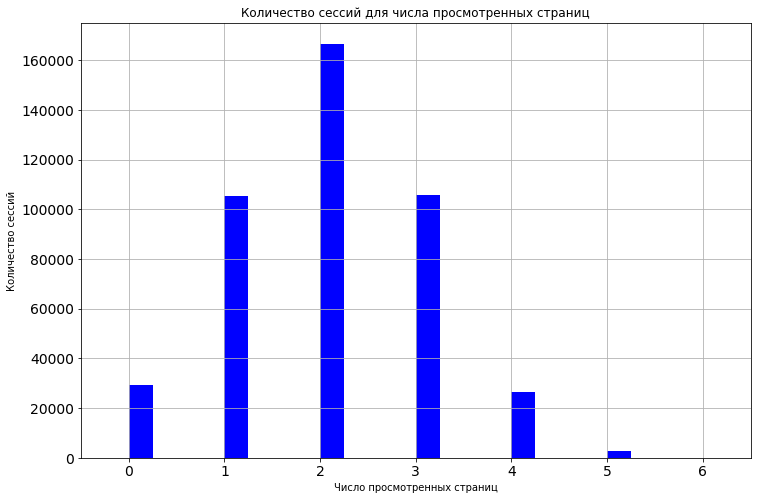

In [11]:

sessions_history.groupby('page_counter')['session_id'].count().reset_index().plot(kind = 'bar',
                                                                                  figsize = (12, 8),
                                                                                 xlabel = 'Число просмотренных страниц',
                                                                                 ylabel = 'Количество сессий',
                                                                                 title = 'Количество сессий для числа просмотренных страниц',
                                                                                 legend = False,
                                                                                 color = 'blue',
                                                                                 rot = 0,
                                                                                 fontsize = 14,
                                                                                 grid = True)
plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [12]:
def good_session(x):
    if x >= 4:
        return 1
    else:
        return 0 

sessions_history['good_session'] = sessions_history['page_counter'].apply(good_session)
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


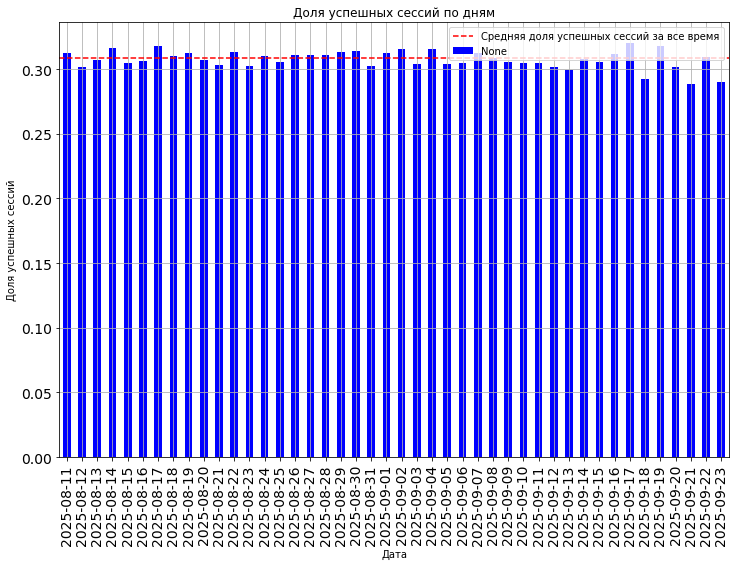

In [13]:
session_good = sessions_history.groupby('session_date').agg({'session_id': 'count', 'good_session': 'sum'})
session_good_rat = session_good['good_session'] / session_good['session_id']
mean = sessions_history['good_session'].mean()

plt.figure(figsize=(12, 8))
session_good_rat.plot(kind='bar',
                     grid=True,
                     xlabel='Дата',
                     ylabel='Доля успешных сессий',
                     title='Доля успешных сессий по дням',
                     color='blue',
                     fontsize=14)
plt.axhline(y=mean, color='r', linestyle='--', label = 'Средняя доля успешных сессий за все время') 
plt.legend()
plt.show()

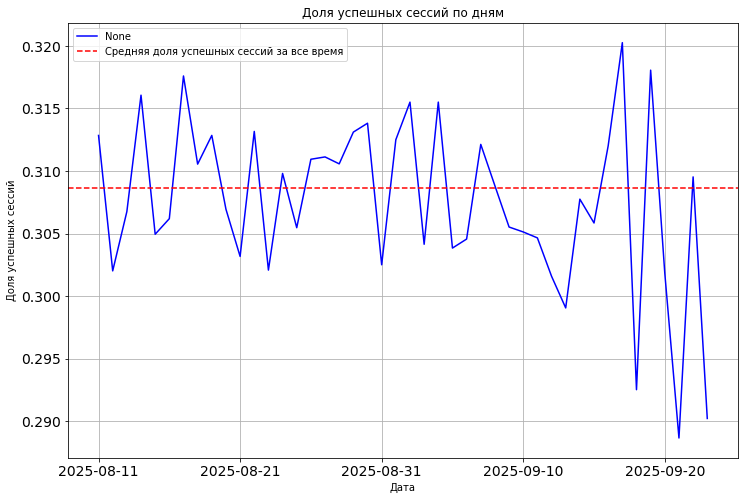

In [14]:
session_good = sessions_history.groupby('session_date').agg({'session_id': 'count', 'good_session': 'sum'})
session_good_rat = session_good['good_session'] / session_good['session_id']
mean = sessions_history['good_session'].mean()

plt.figure(figsize=(12, 8))
session_good_rat.plot(kind='line',
                     grid=True,
                     xlabel='Дата',
                     ylabel='Доля успешных сессий',
                     title='Доля успешных сессий по дням',
                     color='blue',
                     fontsize=14)
plt.axhline(y=mean, color='r', linestyle='--', label = 'Средняя доля успешных сессий за все время') 
plt.legend()
plt.show()

#### Промежуточные выводы по разделу:
1) В данных не обнаружено пропусков и полных дубликатов
2) Наблюдается рост доли зарегистрированных пользователей, посещающих приложение, к концу наблюдаемого периода. Однако, наблюдается также снижение общего количества пользователей, посещающих приложение. Поэтому увеличение доли зарегистрированных пользователей скорее связано с понижемнием общего числа пользователей. С одной стороны существует положительная тенденция по вовлеченности зарегистрированных пользователей. С другой стороны снижение общего количества пользователей, использующих приложение, сигнализирует о возможных проблемах с удержанием новых пользователей и требует дополнительных мер по их удержанию.
3) Доля сессий, в рамках которых было просмотрено 4 и более страниц, колеблется в пределах 28% - 33% в течение наблюдаемого преиода. При этом ближе к концу наблюдаемого периода колебание доли таких сессий становится более резким по сравнению с началом.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [15]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [16]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(int(sample_size)*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {int(avg_daily_users)} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [17]:
#sessions_test_part = pd.read_csv('sessions_project_test_part.csv')
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')
sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique(), sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique() 

(1477, 1466)

In [18]:
test_group = sessions_test_part.groupby('test_group')['user_id'].nunique()
A = test_group.iloc[0]
B = test_group.iloc[1]
P = round(100 * abs(A-B) / A, 2)
print(f'Процентная разница в количестве пользователей в группах A и B: {P}')

Процентная разница в количестве пользователей в группах A и B: 0.74


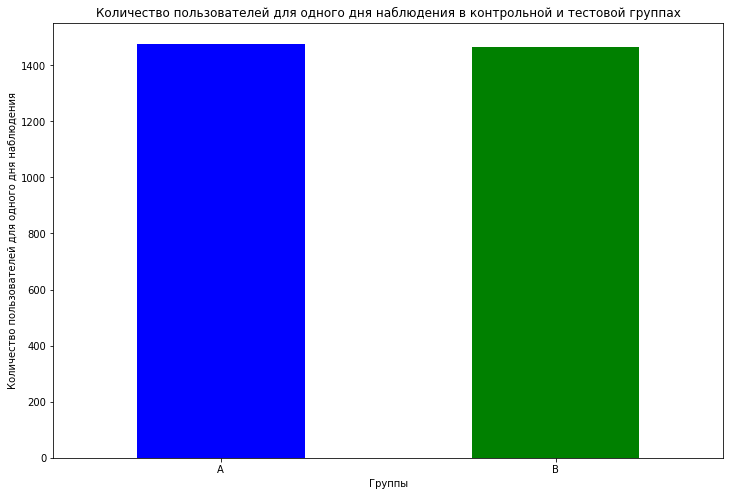

In [19]:
plt.figure(figsize=(12, 8))
sessions_test_part.groupby('test_group')['user_id'].nunique().plot(kind='bar',
                                                                  color = ['blue', 'green'],
                                                                  rot = 0,
                                                                  xlabel = 'Группы',
                                                                  ylabel = 'Количество пользователей для одного дня наблюдения',
                                                                  title = 'Количество пользователей для одного дня наблюдения в контрольной и тестовой группах')
plt.show()

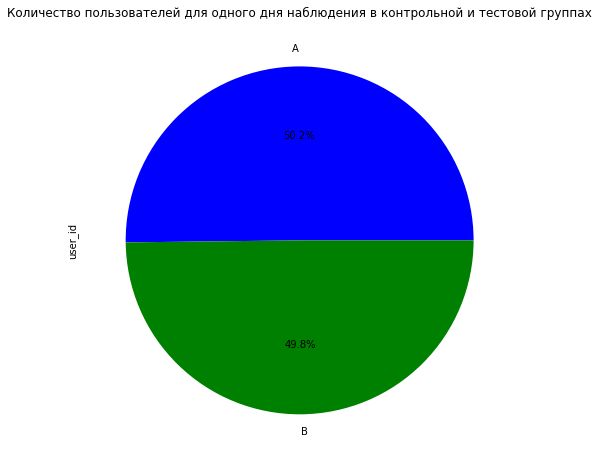

In [20]:
plt.figure(figsize=(12, 8))
a = ['blue', 'green']
sessions_test_part.groupby('test_group')['user_id'].nunique().plot(kind='pie',
                                                                  colors=a, 
                                                                  autopct='%1.1f%%',
                                                                  title = 'Количество пользователей для одного дня наблюдения в контрольной и тестовой группах')
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [21]:
A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(A) & set(B))
print(intersection) 

[]


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [22]:
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


/tmp/ipykernel_34/2912008851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_A['rat'] = group_A['user_id'] / group_A['user_id'].sum()
/tmp/ipykernel_34/2912008851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_B['rat'] = group_B['user_id'] / group_B['user_id'].sum()


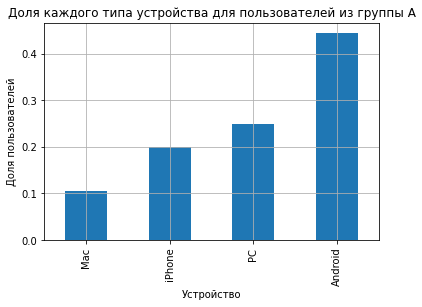

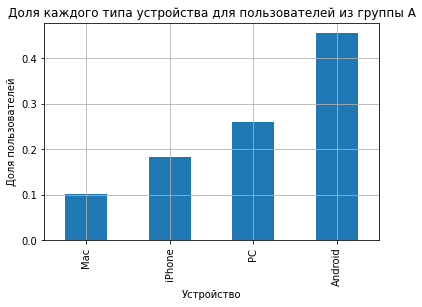

In [23]:
unique_users = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().reset_index()
group_A = unique_users[unique_users['test_group'] == 'A']
group_B = unique_users[unique_users['test_group'] == 'B']

group_A['rat'] = group_A['user_id'] / group_A['user_id'].sum()
group_A.sort_values(by = 'rat').plot(kind = 'bar', x = 'device', y = 'rat', legend = False, grid = True,
            xlabel = 'Устройство', ylabel = 'Доля пользователей', title = 'Доля каждого типа устройства для пользователей из группы A')

group_B['rat'] = group_B['user_id'] / group_B['user_id'].sum()
group_B.sort_values(by = 'rat').plot(kind = 'bar', x = 'device', y = 'rat', legend = False, grid = True,
            xlabel = 'Устройство', ylabel = 'Доля пользователей', title = 'Доля каждого типа устройства для пользователей из группы A')

plt.show()


#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


/tmp/ipykernel_34/1381278967.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_A['rat'] = group_A['user_id'] / group_A['user_id'].sum()
/tmp/ipykernel_34/1381278967.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_B['rat'] = group_B['user_id'] / group_B['user_id'].sum()


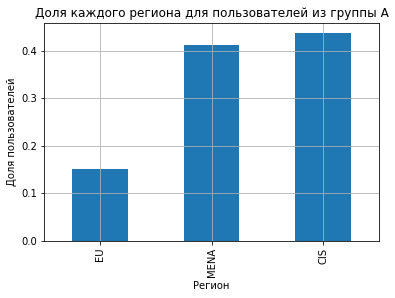

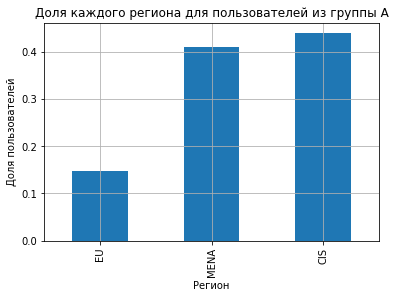

In [24]:
unique_users = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().reset_index()
group_A = unique_users[unique_users['test_group'] == 'A']
group_B = unique_users[unique_users['test_group'] == 'B']

group_A['rat'] = group_A['user_id'] / group_A['user_id'].sum()
group_A.sort_values(by = 'rat').plot(kind = 'bar', x = 'region', y = 'rat', legend = False, grid = True,
            xlabel = 'Регион', ylabel = 'Доля пользователей', title = 'Доля каждого региона для пользователей из группы A')

group_B['rat'] = group_B['user_id'] / group_B['user_id'].sum()
group_B.sort_values(by = 'rat').plot(kind = 'bar', x = 'region', y = 'rat', legend = False, grid = True,
            xlabel = 'Регион', ylabel = 'Доля пользователей', title = 'Доля каждого региона для пользователей из группы A')

plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

#### Выводы после проверки A/B-тесты:
1) Обнаружены различия в количестве пользователей в двух группах. Однако, можно сказать, что данное разлие на текущем этапе не значительно, так как состаляет менее 1%
2) Установлено, что выборки являются независимыми, так пересечение пользователей из тестовой и контрольной групп не наблюдается
3) По проведенному анализу можно сделать вывод, что в группах распределения ппользователей тестовой и контрольной групп по категориальныи переменным (устройствам и регионам) сохраняется. Сильных различий не было обнаружено

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [25]:
#sessions_test = pd.read_csv('sessions_project_test.csv')
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

def good_session(x):
    if x >= 4:
        return 1
    else:
        return 0 

sessions_test['good_session'] = sessions_test['page_counter'].apply(good_session)
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


In [26]:
participants_count = sessions_test['user_id'].nunique()
print(f'Количество пользователей, участвовавших в проведении эксперимента: {participants_count}')

duration = pd.to_datetime(sessions_test['session_date'].max()) - pd.to_datetime(sessions_test['session_date'].min())
print(f'Длительность эксперимента: {duration}')

Количество пользователей, участвовавших в проведении эксперимента: 30579
Длительность эксперимента: 19 days 00:00:00


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [27]:
sessions_test.groupby(['test_group','session_date'])['session_id'].nunique().reset_index()

,test_group,session_date,session_id
0,A,2025-10-14,1502
1,A,2025-10-15,2235
2,A,2025-10-16,3280
3,A,2025-10-17,4089
4,A,2025-10-18,5013
5,A,2025-10-19,6535
6,A,2025-10-20,5837
7,A,2025-10-21,3927
8,A,2025-10-22,3083
9,A,2025-10-23,2470


Нулевая гипотеза: <br>
Различий в выборочных средних количества сессий пользователей из группы A и B нет: <br>
H0: muA = muB<br>
<br>
Тогда альтернативная гипотеза: <br>
Выборочные средние количества сессий пользователей в группах A и B различаются:<br>
H1: muA не = muB <br>


In [28]:
# H0 среднее по выборке А = среднее по выборке B
# H1 H0 среднее по выборке А не= среднее по выборке B

sessions_test_grouped = sessions_test.groupby(['test_group', 'session_date'])['session_id'].nunique().reset_index()

sample_a = sessions_test_grouped[(sessions_test_grouped['test_group'] == 'A')]['session_id']
sample_b = sessions_test_grouped[(sessions_test_grouped['test_group'] == 'B')]['session_id']

test_result = ttest_ind(sample_a, sample_b, alternative='two-sided')

alpha = 0.05

print(f'Значение p-value: {round(test_result.pvalue, 2)}')
if test_result.pvalue > alpha:
    print(f'p-value = {round(test_result.pvalue, 2)} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'p-value = {round(test_result.pvalue, 2)} < {alpha}')
    print('Отвергаем нулевую гипотезу') 


Значение p-value: 0.94
p-value = 0.94 > 0.05
Не получилось отвергнуть нулевую гипотезу


Полученное значение p_value больше установленного значения alpha. Следовательно, можно склониться к принятию нулевой гипотезы, которая утверждает, что средние значения количества пользовательских сессий в группах A и B равны.

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [29]:
group_A = sessions_test[(sessions_test['test_group'] == 'A')]
A = group_A['good_session'].mean() * 100
print(f'Доля успешных сессий в группе A: {round(A,2)}%')


group_B = sessions_test[(sessions_test['test_group'] == 'B')]
B = group_B['good_session'].mean() * 100
print(f'Доля успешных сессий в группе B: {round(B,2)}%')

difference = round(abs(A - B), 2)

print(f'Разница между долей успешных сессий в группе A и B составляет {difference}%')

Доля успешных сессий в группе A: 30.77%
Доля успешных сессий в группе B: 31.83%
Разница между долей успешных сессий в группе A и B составляет 1.06%


Доля успешных сессий для тестовой группы примерно на 1.1% выше, чем в контрольной.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

Нулевая гипотеза: <br>
Доли успешных сессий в группах A и B равны:<br>
pA = pB<br>
<br>
Альтернативная гипотеза: <br>
Доля успешных сессий в группе B выше чем в группе A:<br>
pA < pB

In [30]:
n_a, n_b = sessions_test[sessions_test.test_group=='A'].shape[0], sessions_test[sessions_test.test_group=='B'].shape[0] 
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session == 1)].shape[0] 
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session == 1)].shape[0] 

p_a, p_b = m_a/n_a, m_b/n_b

alpha = 0.05 

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' 
)



print(f'Значение p-value: {round(p_value_ztest, 4)}')

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

Значение p-value: 0.0002
pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!


На основании проведенного Z-теста удалось подтвердить, что различие в доле успешных сессий между пользователями контрольной и тестовой группы является статистическим значимым.

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

#### Выводы по результатам A/B эксперимента
1) Эксперимент длился 19 дней, в течении которых было задействовано 30 579 пользователей;

2) Введение нового алгоритма рекомендаций позволило увеличить долю успешных сессий на 1.1% в тестовой группе;

3) Для проверки статистической значимости полученного изменения был проведен Z-тест пропорций. Полученное изменение можно считать статистически значимым на основании значения p_value - 0.0002, что ниже установленного уровня значимости (alpha = 0.05) и позволяет отвергнуть нулевую гипотезу о равенстве долей успешных сессий в контрольной и тестовой группах;

4) Разработанный алгоритм рекоммендаций может быть внедрен в приложение для повышения вовлеченности пользователей.